In [24]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

from utils import GraphGenerator

erdos_renyi_graph = GraphGenerator.erdos_renyi_generator(n=20, p=0.1)  # Example parameters
waxman_graph = GraphGenerator.waxman_generator_1(n=10, alpha=0.1, beta=0.1)  # Example parameters

graphs = {
    'Erdos-Renyi': erdos_renyi_graph,
    'Waxman': waxman_graph
}

number_of_flows = [i for i in range(0, 101, 10)]

Evaluating edge 1,2
Evaluating edge 1,3
Evaluating edge 1,4
Evaluating edge 1,5
Evaluating edge 1,6
Evaluating edge 1,7
Evaluating edge 1,8
Evaluating edge 1,9
Evaluating edge 1,10
Evaluating edge 1,11
Evaluating edge 1,12
Evaluating edge 1,13
Evaluating edge 1,14
Evaluating edge 1,15
Evaluating edge 1,16
Evaluating edge 1,17
Evaluating edge 1,18
Evaluating edge 1,19
Evaluating edge 1,20
Evaluating edge 2,3
Evaluating edge 2,4
Evaluating edge 2,5
Evaluating edge 2,6
Evaluating edge 2,7
Evaluating edge 2,8
Evaluating edge 2,9
Evaluating edge 2,10
Evaluating edge 2,11
Evaluating edge 2,12
Evaluating edge 2,13
Evaluating edge 2,14
Evaluating edge 2,15
Evaluating edge 2,16
Evaluating edge 2,17
Evaluating edge 2,18
Evaluating edge 2,19
Evaluating edge 2,20
Evaluating edge 3,4
Evaluating edge 3,5
Evaluating edge 3,6
Evaluating edge 3,7
Evaluating edge 3,8
Evaluating edge 3,9
Evaluating edge 3,10
Evaluating edge 3,11
Evaluating edge 3,12
Evaluating edge 3,13
Evaluating edge 3,14
Evaluating ed

In [2]:
def generate_random_flows(graph: nx.Graph, m: int) -> dict[int, [int]]:
    flows = {}
    flow_set = set()  # deduplicate
    nodes = list(graph.nodes())  # Assume nodes are already integers or convertible to integers
    while len(flow_set) < m:
        source = random.choice(nodes)
        target = random.choice([node for node in nodes if node != source])
        paths = list(nx.all_simple_paths(graph, source=source, target=target))
        if paths:
            selected_path = random.choice(paths)
            converted_path = (int(node) for node in selected_path)
            flow_set.add(converted_path)
    for index, flow in zip(range(m), flow_set):
        flows[index] = list(flow)

    return flows

In [3]:
def generate_switch_flow_list(flows) -> dict[int, [int]]:
    switch_flow_dict = {}

    for flow_id, switches in flows.items():
        for switch_id in switches:
            switch_id = int(switch_id)
            switch_flow_dict.setdefault(switch_id, set()).add(flow_id)

    return {switch_id: list(flow_ids) for switch_id, flow_ids in switch_flow_dict.items()}

In [4]:
from utils.SetCover import set_cover_solve

def calculate_naive_cost(graph, flows):
    # Each request is 122 bytes and each reply is 174 bytes
    request_size = 122
    reply_size = 174
    total_cost = 0

    for flow in flows.values():
        total_cost += request_size + reply_size

    return total_cost

def calculate_optimized_cost(flow_ids, switch_flow_list):
    optimized_set = set_cover_solve(flow_ids, switch_flow_list)
    total_cost = 0
    
    for switch_id, flows in optimized_set.items():
        total_cost += 122 + 78 + 96 * len(flows)
        
    return total_cost

# Figure 4

In [4]:
results = []

for name, graph in graphs.items():
    for flow_count in number_of_flows:
        flows = generate_random_flows(graph, flow_count)
        flow_ids = list(flows.keys())
        switch_flow_list = generate_switch_flow_list(flows)
        
        naive_cost = calculate_naive_cost(graph, flows)
        optimized_cost = calculate_optimized_cost(flow_ids, switch_flow_list)
        results.append({
            'Graph': name,
            'Number of Flows': flow_count,
            'Naive Cost': naive_cost,
            'Optimized Cost': optimized_cost
        })

All flows have been successfully covered.
Picked switch 8 covering flows {0, 1, 2, 3, 4, 5, 6, 7, 8, 9} with ratio 90.2.
All flows have been successfully covered.
Picked switch 3 covering flows {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18} with ratio 84.42105263157895.
Randomly picked switch 8 for single flow 19 due to high ratio or no better option.
All flows have been successfully covered.
Picked switch 3 covering flows {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 23, 24, 26, 28, 29} with ratio 82.88.
Randomly picked switch 7 for single flow 27 due to high ratio or no better option.
Randomly picked switch 7 for single flow 25 due to high ratio or no better option.
Randomly picked switch 8 for single flow 21 due to high ratio or no better option.
Randomly picked switch 8 for single flow 17 due to high ratio or no better option.
Randomly picked switch 8 for single flow 19 due to high ratio or no better option.
All flows have been successfu

# Save Results to CSV

In [5]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"data/figure_4_{timestamp}.csv"

# Ensure the stats directory exists
os.makedirs(os.path.dirname(filename), exist_ok=True)

# Convert results to DataFrame and save as CSV
df = pd.DataFrame(results)
df.to_csv(filename, index=False)

print(f"Results saved to {filename}")

Results saved to data/flow_stats_20240611-204302.csv


# Plot the Graph Figure 4

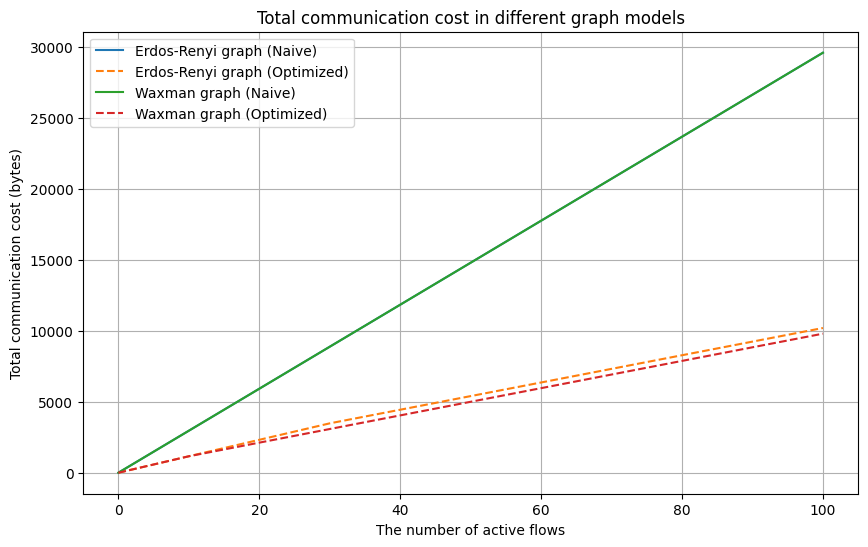

In [7]:
# Plot the graph
df = pd.read_csv(filename)

plt.figure(figsize=(10, 6))
for graph in df['Graph'].unique():
    graph_df = df[df['Graph'] == graph]
    plt.plot(graph_df['Number of Flows'], graph_df['Naive Cost'], label=f'{graph} graph (Naive)')
    plt.plot(graph_df['Number of Flows'], graph_df['Optimized Cost'], label=f'{graph} graph (Optimized)', linestyle='--')

plt.xlabel('The number of active flows')
plt.ylabel('Total communication cost (bytes)')
plt.title('Total communication cost in different graph models')
plt.legend()
plt.grid(True)
plt.show()

# Figure 10

In [31]:
initial_flows = 100
req_cost = 122
header_cost = 78
stats_per_flow = 96
graph = graphs["Erdos-Renyi"]
flows = generate_random_flows(graph, initial_flows)
flow_ids = list(flows.keys())
switch_flow_list = generate_switch_flow_list(flows)

# Simulation parameters
simulation_time = 60  # seconds
recompute_interval = 5  # seconds

# Unique flow ID counter for new flows
flow_id_counter = max(flow_ids) + 1

# Initialize results
results = {
    'Time': [],
    'Per-flow Cost': [],
    'Recompute Cost': [],
    'Heuristic Cost': []
}
# Initialize heuristic data
current_optimized_set = set_cover_solve(flow_ids, switch_flow_list)
last_recompute_time = 0

# Run the simulation
for t in range(simulation_time):
    # Add new flows
    new_flow_count = random.randint(0, 10)
    new_flows = generate_random_flows(graph, new_flow_count)
    
    for flow in new_flows.values():
        flows[flow_id_counter] = flow
        flow_id_counter += 1
        
     # Randomly delete flows
    delete_flow_count = random.randint(0, 10)
    if delete_flow_count > 0 and flows:
        delete_keys = random.sample(list(flows.keys()), min(delete_flow_count, len(flows)))
        for key in delete_keys:
            del flows[key]
    
    flow_ids = list(flows.keys())
    switch_flow_list = generate_switch_flow_list(flows)
    
     # Check if the new flows are already covered
    covered_flows = set()
    for flow_id, path in new_flows.items():
        for switch_id in path:
            if switch_id in current_optimized_set:
                covered_flows.add(flow_id)
                break
    
    # Calculate costs per-flow
    per_flow_cost = calculate_naive_cost(graph, flows)
    
    # Recompute
    recompute_cost = calculate_optimized_cost(flow_ids, switch_flow_list)
    
    # Heruistic
    if t % recompute_interval == 0:
        heuristic_cost = calculate_optimized_cost(flow_ids, switch_flow_list)
        current_optimized_set = set_cover_solve(flow_ids, switch_flow_list)
        last_recompute_time = t
    else:
        for flow_id in new_flows:
            if flow_id not in covered_flows:
                heuristic_cost += req_cost + header_cost + stats_per_flow
            else: 
                heuristic_cost += stats_per_flow
    if t - last_recompute_time >= recompute_interval:
        current_optimized_set = set_cover_solve(flow_ids, switch_flow_list)
        last_recompute_time = t
    
    # Update results
    results['Time'].append(t)
    results['Per-flow Cost'].append(per_flow_cost)
    results['Recompute Cost'].append(recompute_cost)
    results['Heuristic Cost'].append(heuristic_cost)

Picked switch 20 covering flows {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 84, 85, 86, 87, 89, 90, 91, 92, 94, 96, 97, 99} with ratio 79.46987951807229.
Picked switch 8 covering flows {81, 83, 21, 55, 27, 95} with ratio 189.33333333333334.
Randomly picked switch 2 for single flow 30 due to high ratio or no better option.
Randomly picked switch 16 for single flow 98 due to high ratio or no better option.
Randomly picked switch 10 for single flow 56 due to high ratio or no better option.
Randomly picked switch 16 for single flow 93 due to high ratio or no better option.
Randomly picked switch 15 for single flow 42 due to high ratio or no better option.
Randomly picked switch 16 for single flow 16 due to high ratio or no better option.
Randomly picked switch 13

# Save Results to CSV

In [32]:
# Convert results to DataFrame
df = pd.DataFrame(results)

# Save results to CSV
timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"data/figure_10_{timestamp}.csv"

# Ensure the data directory exists
os.makedirs(os.path.dirname(filename), exist_ok=True)

# Save DataFrame to CSV
df.to_csv(filename, index=False)

print(f"Results saved to {filename}")

Results saved to data/figure_10_20240612-160048.csv


# Plot the Graph Figure 10

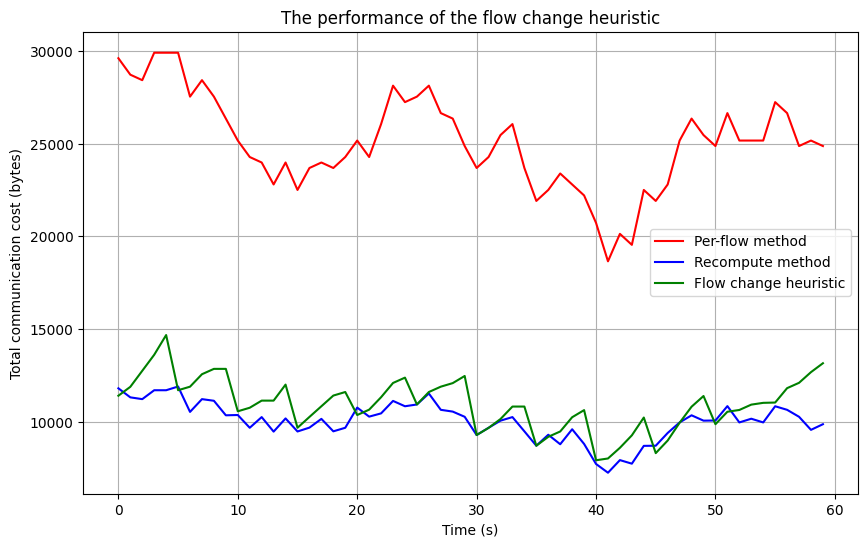

In [33]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Per-flow Cost'], label='Per-flow method', color='red')
plt.plot(df['Time'], df['Recompute Cost'], label='Recompute method', color='blue')
plt.plot(df['Time'], df['Heuristic Cost'], label='Flow change heuristic', color='green')

plt.xlabel('Time (s)')
plt.ylabel('Total communication cost (bytes)')
plt.title('The performance of the flow change heuristic')
plt.legend()
plt.grid(True)
plt.show()